# Continuous Control with A2C

In this repo, I will be implementing A2C with Generalized Advantage Estimation to solve the Unity ML-Agents' [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/main/docs/Learning-Environment-Examples.md#reacher) environment as part of my Udacity DRL Nanodegree course.

The below implementation will use A2C.
<br />
<br />

### 1. Environment

In [1]:
from sys import platform
import time
import os.path
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from unityagents import UnityEnvironment

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you are running.

- **Mac**: `"environments/Reacher.app"`
- **Windows** (x86): `"environments/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"environments/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"environments/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"environments/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"environments/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"environments/Reacher_Linux_NoVis/Reacher.x86_64"`

In [3]:
def load_env():
    if platform.startswith('linux'):
        return UnityEnvironment(file_name="../reacher/Reacher_Linux_NoVis/Reacher.x86_64", no_graphics=True)
    elif platform.startswith('darwin'):
        return UnityEnvironment(file_name="../reacher/Reacher.app")
    else:
        raise NotImplemented()

reacher_env = load_env()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = reacher_env.brain_names[0]
brain = reacher_env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_data = reacher_env.reset(train_mode=True)[brain_name]

# number of agents
print('Number of agents:', len(env_data.agents))

# size of each action
print('Size of each action:', brain.vector_action_space_size)

# examine the state space 
print('There are {} agents. Each observes a state with length: {}'.format(env_data.vector_observations.shape[0], env_data.vector_observations.shape[1]))
print('The state for the first agent looks like:', env_data.vector_observations[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

The next code cell demonstrates how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Over the next sections, we will build an agent that is able to use its experiences to gradually choose better actions when interacting with the environment.

*Uncomment the lines in the code cell below to run it*

In [6]:
# env_info = reacher_env.reset(train_mode=False)[brain_name]     # reset the environment
# states = env_data.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# count = 0
# while True:
#     count += 1
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = reacher_env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_data.vector_observations         # get next state (for each agent)
#     rewards = env_data.rewards                         # get reward (for each agent)
#     dones = env_data.local_done                        # see if episode finished
#     scores += env_data.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. Implementation

#### A2C

The algorithm used for solving the environment will be Advantage Actor Critic (A2C), which is a synchronous implementation of Asynchronous Advantage Actor Critic (A3C) with several additional enhancements:
- it leverages a weight-sharing model for its actor and its critic
- it performs Generalized Advantage Estimation in calculating the policy loss
- it normalizes the state observations using a running mean and std, which has improved training stability

In the implementation of A2C below, the code is mostly self-documenting, but there are a few features to highlight:
- an evaluation of the policy model is done at the end of each full episode (i.e. every 1001 timesteps)
- optimization of the policy is done every 5 timesteps using the collected experiences of all 20 agents
- the training terminates when the mean score is 35 points over the previous 100 evaluated episodes averaged across all 20 agents.
- Refer to the `config` object below for the selected hyperparameters, mostly selected based on trial and error.

##### Gaussian Actor Critic Model Architecture
A single actor-critic neural network architecture will be used:
- the state input has dim 33
- the first input layer is of shape (33, 128) with a Relu activation
- from second layer is a hidden layer of shape (128, 128) with a Relu activation; this layer is shared by both the actor head and critic head
- the third layers are split per actor and critic with dims of (128, 128) and (128, 128) respectively and Relu activation
- the fourth layer is the output layer for the actor and critic
  - the actor outputs a mean and log_std with no additional activation function represented by dims (128, 4) and (128, 4) each. 4 represents the action-size.
  - the critic outputs a value with dim of (128, 1) representing a single assessment of the state value

Refer to the comments in the code below for explanation of specifics of the implementation in the `__init__`, `forward`, and `sample` functions.

In [7]:
class GaussianActorCriticModel(nn.Module):
    def __init__(self, state_dim, action_dim, common_hidden_dims, actor_hidden_dims=(128,128), critic_hidden_dims=(128,128), activation_fn=F.relu):
        super(GaussianActorCriticModel, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation_fn = activation_fn
        self.input_layer = nn.Linear(state_dim, common_hidden_dims[0])

        # Sharing several hidden layers and their weights for efficiency of the critic
        self.common_hidden_layers = nn.ModuleList()
        for i in range(len(common_hidden_dims) - 1):
            self.common_hidden_layers.append(nn.Linear(common_hidden_dims[i], common_hidden_dims[i + 1]))

        # actor-specific hidden layers
        self.actor_hidden_layers = nn.ModuleList()
        self.actor_hidden_layers.append(nn.Linear(common_hidden_dims[-1], actor_hidden_dims[0]))
        for i in range(len(actor_hidden_dims) - 1):
            self.actor_hidden_layers.append(nn.Linear(actor_hidden_dims[i], actor_hidden_dims[i + 1]))

        # For a continuous action space, this network will output a mean and log standard deviation from which to sample actions
        self.actor_output_mean = nn.Linear(actor_hidden_dims[-1], action_dim)
        self.actor_output_log_std = nn.Linear(actor_hidden_dims[-1], action_dim)

        # critic-specific hidden layers
        self.critic_hidden_layers = nn.ModuleList()
        self.critic_hidden_layers.append(nn.Linear(common_hidden_dims[-1], critic_hidden_dims[0]))
        for i in range(len(critic_hidden_dims) - 1):
            self.critic_hidden_layers.append(nn.Linear(critic_hidden_dims[i], critic_hidden_dims[i + 1]))
        self.critic_output_value = nn.Linear(critic_hidden_dims[-1], 1)
        self.to(self.device)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32, device=self.device)

        x = self.activation_fn(self.input_layer(state))
        for layer in self.common_hidden_layers:
            x = self.activation_fn(layer(x))

        x_actor = x
        for layer in self.actor_hidden_layers:
            x_actor = self.activation_fn(layer(x_actor))
        mean = self.actor_output_mean(x_actor)
        log_std = self.actor_output_log_std(x_actor)
        log_std = torch.clamp(log_std, -20, 2) # Clamp the log_std to a usable range

        x_critic = x
        for layer in self.critic_hidden_layers:
            x_critic = self.activation_fn(layer(x_critic))
        state_value = self.critic_output_value(x_critic)

        return mean, log_std, state_value

    def sample(self, state):
        mean, log_std, state_value = self.forward(state)
        std = log_std.exp()  # Using the exp() function ensures the std is positive
        dist = torch.distributions.Normal(mean, std)
        action = dist.rsample()  # Using rsample to keep the sampling function differentiable
        tanh_action = torch.tanh(action)  # Rescale the action to between -1 and 1 required by the env

        # From SAC paper (arXiv 1801.01290, Appendix C), the below is a correction to rescale the lob_prob to the tanh range
        log_prob = (dist.log_prob(action) - torch.log((1 - tanh_action.pow(2)).clamp(0, 1) + 1e-8)).sum(1, keepdim=True)

        entropy = dist.entropy().sum(1, keepdim=True)

        return tanh_action, log_prob, entropy, state_value

    def sample_action(self, state):
        mean, log_std, _ = self.forward(state)
        std = log_std.exp()
        dist = torch.distributions.Normal(mean, std)
        action = dist.rsample()
        return torch.tanh(action)

    def sample_greedy_action(self, state):
        mean, _, _ = self.forward(state)
        return torch.tanh(mean)

    def get_state_value(self, state):
        _, _, state_value = self.forward(state)
        return state_value

In [8]:
# RunningMeanStd implementation from https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py
class RunningMeanStd(object):
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = self.update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)

    @staticmethod
    def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
        delta = batch_mean - mean
        tot_count = count + batch_count

        new_mean = mean + delta * batch_count / tot_count
        m_a = var * count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        return new_mean, new_var, new_count

class A2CAgent():
    def __init__(self, reacher_env, checkpoint_dir=os.path.join(os.path.dirname(os.path.realpath('__file__')), 'checkpoints')):
        self.env = reacher_env
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.checkpoint_dir = checkpoint_dir
        self.running_mean_std = None

    def train(self, seed, learning_rate, hidden_dims, discount_rate, gae_lambda, value_loss_weight, entropy_loss_weight, gradient_clip, optimize_interval_timesteps, save_interval_episodes, goal_mean_score_100, max_episode_count, max_duration_minutes):
        #setup
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.seed = seed
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.gae_lambda = gae_lambda
        self.value_loss_weight = value_loss_weight
        self.entropy_loss_weight = entropy_loss_weight
        self.gradient_clip = gradient_clip

        env_info, num_agents, action_dim, state_dim, states = self._reset_env()
        self.num_agents = num_agents
        self.gac_model = GaussianActorCriticModel(state_dim, action_dim, common_hidden_dims=hidden_dims)
        self.optimizer = torch.optim.Adam(self.gac_model.parameters(), learning_rate)

        # start training
        self._reset_training_data()
        self._reset_stats(reset_training_stats=True)
        print(">>>Started Training<<<")
        while True:
            states, dones = self._step(self._normalize_states(states))
            episode_done = np.any(dones)

            if (self.timesteps > 0 and self.timesteps % optimize_interval_timesteps == 0) or episode_done:
                next_state_value = self.gac_model.get_state_value(self._normalize_states(states))
                self.rewards.append(next_state_value.cpu().detach().numpy())
                self.state_values.append(next_state_value)
                self.optimize()
                self._reset_training_data()

            if episode_done:
                episode_end_timestamp = time.time() # episode duration is calculated after policy optimization and before evaluation
                self.episode_timesteps.append(self.timesteps)
                self.episode_timestamps.append(episode_end_timestamp)
                duration = episode_end_timestamp - self.episode_start_timestamp
                self.episode_durations.append(duration)

                eval_scores, eval_mean_score = self.evaluate()
                self.eval_scores.append(eval_scores)
                self.eval_mean_scores.append(eval_mean_score)
                self.eval_mean_score_100 = np.mean(self.eval_mean_scores[-100:])

                if self.episode_count >= max_episode_count:
                    self._print_training_status(">>>Stopped Training: Max Episodes<<<")
                    self.save()
                    break
                if (episode_end_timestamp - self.training_start_timestamp) >= max_duration_minutes * 60:
                    self._print_training_status(">>>Stopped Training: Max Duration<<<")
                    self.save()
                    break
                if self.episode_count > 100 and self.eval_mean_score_100 >= goal_mean_score_100:
                    self._print_training_status("***Stopped Training: Target Performance Achieved***")
                    self.save()
                    break

                if self.episode_count > 0 and self.episode_count % save_interval_episodes == 0:
                    self.save()

                self._print_training_status()
                self._reset_stats(reset_training_stats=False)
                _, _, _, _, states = self._reset_env()
                self.episode_count += 1

    def optimize(self):
        log_probs = torch.stack(self.log_probs).squeeze()
        entropies = torch.stack(self.entropies).squeeze()
        state_values = torch.stack(self.state_values).squeeze()
        rewards = np.array(self.rewards).squeeze()

        if entropies.shape == (20,):
            log_probs = log_probs.unsqueeze(0)
            entropies = entropies.unsqueeze(0)

        np_state_values = state_values.cpu().detach().numpy()
        terminal_mask = (1 - np.array(self.dones))

        assert (rewards.shape == np_state_values.shape)
        t_max = len(rewards)

        returns = np.full((t_max - 1, 20), np.nan)
        gaes = np.full((t_max - 1, 20), np.nan)
        return_t = np_state_values[-1]
        gae_t = np.zeros(self.num_agents)
        for t in reversed(range(t_max - 1)):
            return_t = rewards[t] + terminal_mask[t] * self.discount_rate * return_t
            adv_t = -np_state_values[t] + rewards[t] + terminal_mask[t] * self.discount_rate * np_state_values[t + 1]
            gae_t = adv_t + terminal_mask[t] * self.gae_lambda * self.discount_rate * gae_t
            returns[t] = return_t
            gaes[t] = gae_t

        returns = torch.FloatTensor(returns).to(self.gac_model.device).detach()
        gaes = torch.FloatTensor(gaes).to(self.gac_model.device).detach()
        policy_loss = -(log_probs * gaes)
        value_loss = (returns - state_values[:-1]).pow(2).mul(0.5)
        entropy_loss = -entropies
        loss = policy_loss + self.value_loss_weight * value_loss + self.entropy_loss_weight * entropy_loss
        self.optimizer.zero_grad()
        loss.mean().backward()
        nn.utils.clip_grad_norm_(self.gac_model.parameters(), self.gradient_clip)
        self.optimizer.step()

    def evaluate(self):
        _, num_agents, _, _, states = self._reset_env(True)
        rewards_sum = np.zeros((num_agents, 1))
        while True:
            actions = self.gac_model.sample_action(self._normalize_states(states))
            actions_np = actions.cpu().detach().numpy()
            env_info = self.env.step(actions_np)[self.brain_name]
            rewards = np.expand_dims(env_info.rewards, 1)
            rewards_sum += rewards
            states = env_info.vector_observations
            dones = env_info.local_done
            if np.any(dones):
                break
        return rewards_sum, np.mean(rewards_sum)

    def save(self, ref=None):
        filename = f'gac_model_{ref or self.episode_count}.tar'
        checkpoint_path = os.path.join(self.checkpoint_dir, filename)
        print(f"Saving {filename}")
        torch.save(self.gac_model.state_dict(), checkpoint_path)

    def load(self, ref=None):
        filename = f'gac_model_{ref or self.episode_count}.tar'
        checkpoint_path = os.path.join(self.checkpoint_dir, filename)
        print(f"Loading {filename}")
        self.gac_model.load_state_dict(torch.load(checkpoint_path))

    def _normalize_states(self, states, clip_zscore=10.0, epsilon=1e-8):
        self.running_mean_std = self.running_mean_std or RunningMeanStd(shape=(1,) + states.shape[1:])
        self.running_mean_std.update(states)
        zscore = (states - self.running_mean_std.mean) / np.sqrt(self.running_mean_std.var + epsilon)
        return np.clip(zscore, -clip_zscore, clip_zscore)

    def _step(self, states):
        actions, log_probs, entropies, state_values = self.gac_model.sample(states)
        actions_np = actions.cpu().detach().numpy()
        env_data = self.env.step(actions_np)[self.brain_name]
        rewards = np.expand_dims(env_data.rewards, 1)

        self.log_probs.append(log_probs)
        self.entropies.append(entropies)
        self.rewards.append(rewards)
        self.state_values.append(state_values)
        dones = env_data.local_done
        self.dones.append(dones)
        self.timesteps += 1

        next_states = env_data.vector_observations

        return next_states, dones

    def _print_training_status(self, message=None):
        duration = time.strftime("%H:%M:%S", time.gmtime(time.time() - self.training_start_timestamp))
        status_message = '{} - episode {:04}, timesteps {:07}, eval score {:.2f}, eval score 100ep {:.2f}'.format(
            duration,
            self.episode_count,
            np.sum(self.episode_timesteps, dtype=np.intc),
            self.eval_mean_scores[-1],
            self.eval_mean_score_100)
        if message:
            print(message)
        print(status_message)

    def _reset_training_data(self):
        self.log_probs = []
        self.entropies = []
        self.rewards = []
        self.state_values = []
        self.dones = []

    def _reset_stats(self, reset_training_stats):
        self.timesteps = 0
        self.episode_start_timestamp = time.time()
        if reset_training_stats:
            self.training_start_timestamp = self.episode_start_timestamp
            self.episode_count = 1
            self.episode_timesteps = []
            self.episode_timestamps = [self.episode_start_timestamp]
            self.episode_durations = []
            self.eval_scores = []
            self.eval_mean_scores = []
            self.eval_mean_score_100 = 0.

    def _reset_env(self, train_mode=True):
        env_info = self.env.reset(train_mode=train_mode)[brain_name]
        num_agents = len(env_info.agents)
        action_dim = brain.vector_action_space_size
        states = env_info.vector_observations
        state_dim = states.shape[1]
        return env_info, num_agents, action_dim, state_dim, states

# torch.autograd.set_detect_anomaly(True)
agent = A2CAgent(reacher_env)
config = {
    "seed": 2022,
    "learning_rate": 0.0008,
    "hidden_dims": (128,128),
    "discount_rate": 0.99,
    "gae_lambda": 0.99,
    "value_loss_weight": .6,
    "entropy_loss_weight": 0.001,
    "gradient_clip": 5,
    "goal_mean_score_100": 35,
    "optimize_interval_timesteps": 5,
    "save_interval_episodes": 100,
    "max_episode_count": 2000,
    "max_duration_minutes": 300,
}
agent.train(**config)

>>>Started Training<<<
00:00:13 - episode 0001, timesteps 0001001, eval score 0.22, eval score 100ep 0.22
00:00:27 - episode 0002, timesteps 0002002, eval score 0.15, eval score 100ep 0.18
00:00:43 - episode 0003, timesteps 0003003, eval score 0.24, eval score 100ep 0.20
00:00:58 - episode 0004, timesteps 0004004, eval score 0.05, eval score 100ep 0.16
00:01:12 - episode 0005, timesteps 0005005, eval score 0.40, eval score 100ep 0.21
00:01:26 - episode 0006, timesteps 0006006, eval score 0.24, eval score 100ep 0.22
00:01:38 - episode 0007, timesteps 0007007, eval score 0.60, eval score 100ep 0.27
00:01:50 - episode 0008, timesteps 0008008, eval score 0.42, eval score 100ep 0.29
00:02:03 - episode 0009, timesteps 0009009, eval score 0.75, eval score 100ep 0.34
00:02:15 - episode 0010, timesteps 0010010, eval score 0.01, eval score 100ep 0.31
00:02:26 - episode 0011, timesteps 0011011, eval score 0.38, eval score 100ep 0.31
00:02:36 - episode 0012, timesteps 0012012, eval score 1.12, eva

/Users/animkar/miniconda3/envs/drl-continuous-control/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/animkar/miniconda3/envs/drl-continuous-control/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


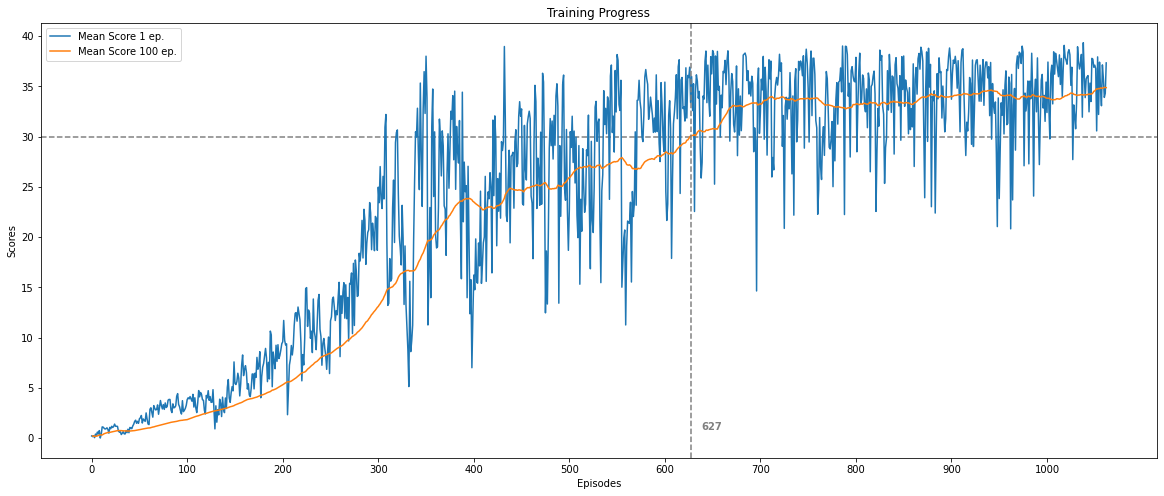

In [9]:
import matplotlib.pyplot as plt
eval_mean_scores = np.array(agent.eval_mean_scores)
eval_mean_100_scores = np.flip([eval_mean_scores[max(t-100, 0):t].mean() for t in reversed(range(len(eval_mean_scores)))])
plt.rcParams['figure.figsize'] = [20, 8]
plt.title("Training Progress")
plt.xticks(np.arange(0, len(eval_mean_scores), step=100))
plt.axhline(y=30, color='grey', linestyle='--')
plt.plot(np.arange(len(eval_mean_scores)), np.array(eval_mean_scores).squeeze(), label="Mean Score 1 ep.")
plt.plot(np.arange(len(eval_mean_100_scores)), np.array(eval_mean_100_scores).squeeze(), label="Mean Score 100 ep.")
threshold_episode = np.argwhere(eval_mean_100_scores >= 30).squeeze()[0]
plt.axvline(x=threshold_episode, color='grey', linestyle='--')
plt.ylabel("Scores")
plt.xlabel("Episodes")
plt.text(threshold_episode + plt.xlim()[1] * 0.02, 0 + plt.ylim()[1]*0.02, str(threshold_episode), horizontalalignment='center', fontweight='bold', color='grey')
plt.legend()

Per the figure above, the environment was solved after 627 episodes, meaning that the mean reward of 100 consecutive episodes averaged across all 20 agents was at least 30.

**The highest performance network parameters have been saved in file "./checkpoints/gac_model_1063.tar".**

#### Ideas to improve performance
The A2C agent above was sample inefficient (discarding previous experiences after training) and also suffered from several drastic reductions in performance after steadily increasing for many episodes (i.e. performance cliffs).

To improve sample efficiency, using an algorithm that leverages a replay buffer to learn from previous experiences would be better. A GPU would be required in this instance and we could batch randomly sampled trajectories to train the policy. This would mean that we use off-policy methods to improve performance.

With regard to the problem of performance cliffs, this is likely due to the small perturbations in network parameters during optimization having a dramatic impact on the policy itself. The gradient update clipping methodology found in PPO would address this problem and prevent performance from "falling off a cliff". Alternatively, we could implement a technique within this A2C implementation for reverting the network parameters to the last known "good" state whenever it is detected that performance has declined; for example, if the 10-episode mean performance is less than the previous 10 episodes, we could load the last known good parameters and decrease the learning rate by a small amount, and then restart training from there. This could stabilize performance and possibly speed up training.

As an aside, the task for finding optimal hyperparameters for the above policy was quite time consuming. We should explore methods for automated hyperparameter search that may be useful for improving model training time. Alternatively, we could find an algorithm with fewer hyperparameters requiring tuning.

It is unclear whether reward normalization could help speed up or stabilize training and should also be explored.